In [28]:
import jax
from jax import jit
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device",jax.devices()[1])
import numpy as np
import jax.numpy as jnp

# from KernelTools import *
from parabolic_data_utils import (
    build_burgers_data,
    build_tx_grid_chebyshev,
)

from KernelTools import diagpart

from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_gaussianRBF
)
from KernelTools import eval_k,dx_k,dxx_k,dt_k
from KernelTools import vectorize_kfunc

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import (
    CholeskyLM,SVD_LM,LMParams,plot_optimization_results
)

from evaluation_metrics import get_nrmse,get_nmae,compute_results
from plotting import plot_input_data,plot_compare_error

import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

In [2]:
# coeffs of Burgers eqn
kappa = 0.01
alpha = 0.5
# IC
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

# solve Burgers eqn
u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999
                        )
)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2930.23it/s]


In [3]:
# size of coll grid
num_grid_x, num_grid_t = 26, 26

# get interior and bdry pts of coll grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

# coll grid
tx_all = jnp.vstack([tx_bdy,tx_int])
# u vals at coll grid
u_all = u_true_function(tx_all)

# idx for IC
init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
# idx for FC
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
# idx for IC + FC
tx_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
# obs grid
tx_obs = jnp.vstack([tx_bdy,tx_int[tx_sample_inds]])
# u vals at obs grid
u_obs = u_true_function(tx_obs)

In [4]:
# fine grid
num_fine_grid = 200
t_fine, x_fine = jnp.meshgrid(jnp.linspace(0,1,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
# u vals at fine grid
u_true = u_true_function(tx_fine)

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

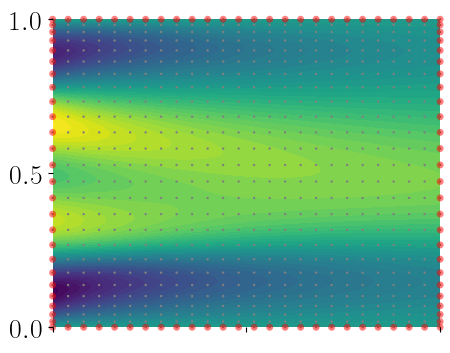

In [5]:
# u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true,
                levels= 50, 
                vmin=-0.4532246910384856, 
                vmax=0.36374402)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 

In [6]:
# x fine grid
xfine = jnp.linspace(0,1,num_fine_grid)
# u vals at fine grid at IC
u_true_IC = u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid), xfine]).T)
# u vals at fine grid at FC
u_true_FC = u_true_function(jnp.vstack([1.0*jnp.ones(num_fine_grid), xfine]).T)

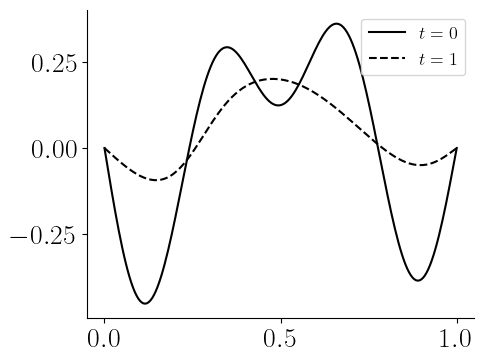

In [7]:
# u_true IC and FC plot
plt.figure(figsize=(5,4))
# Plot IC
plt.plot(xfine, u_true_IC,
         color = 'black',
         label = r'$t=0$')
# Plot FC
plt.plot(xfine,u_true_FC,
         linestyle = '--',
         color = 'black',
         label = r'$t=1$')

# fig settings
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="upper right",fontsize = 13)

In [16]:
# get formatted data to input into PINNSR
def get_data_for_pinns(num_grid_t, num_grid_x):
    
    # Solve Burgers' equations with IC u_0_true_function
    kappa = 0.01
    alpha = 0.5

    def func_u0(x):
        u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
        return u0

    u_true_function,ut_true_function,interpolant,t_vals,sols = (
        build_burgers_data(func_u0=func_u0,
                           kappa = kappa,
                           alpha = alpha,
                           k_timestep=0.0001,
                           n_finite_diff=1999)
                            )

    # get interior and bdry pts of coll grid
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

    # coll grid
    tx_all = jnp.vstack([tx_bdy,tx_int])
    # u vals at coll grid
    u_all = u_true_function(tx_all)

    # idx for IC
    init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
    num_init_obs_inds = len(init_obs_inds)
    # idx for FC
    final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
    # idx for IC + FC
    tx_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
    # obs grid
    tx_obs = jnp.vstack([tx_bdy,tx_int[tx_sample_inds]])
    # u vals at obs grid
    u_obs = u_true_function(tx_obs)

    # fine grid
    num_fine_grid = 200
    t_fine, x_fine = jnp.meshgrid(jnp.linspace(0,1,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    # u vals at fine grid
    u_true = u_true_function(tx_fine)

    #### u true plot
    # u_true plot
    plt.figure(figsize=(5,4))
    plt.tricontourf(*tx_fine.T, u_true,
                    levels= 50, 
                    vmin=-0.4532246910384856, 
                    vmax=0.36374402)
    # coll grid
    plt.scatter(*tx_all.T,
                c='gray',
                s = 3,
                clip_on =False, 
                edgecolors = 'none')
    # obs grid
    plt.scatter(*tx_obs.T,
                c='red', 
                s = 25, 
                alpha = 0.5,
                clip_on =False,
                edgecolors = 'none')

    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([]) 
    ####
    
    # Invert them to be ready for PINNSR 
    tx_train = tx_obs 
    u_train = u_true_function(tx_train) 
    
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    u_val = u_true_function(tx_val)
    

    # limits
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)


    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    

    return [u_true, tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2918.97it/s]


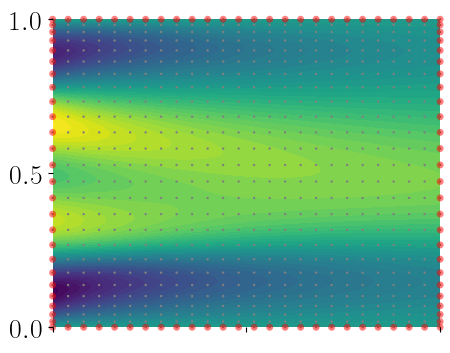

In [15]:
# get data
data_in_PINNSR = get_data_for_pinns(num_grid_t = 26, num_grid_x = 26)
# convert to numpy
data_in_PINNSR = list(map(np.array,data_in_PINNSR))

In [85]:
# save data to be used in PINNSR env
np.save('data_in_PINNSR.npy', np.array(data_in_PINNSR, dtype=object), allow_pickle=True)

In [17]:
# read output data from PINNSR
data_out_PINNSR = jnp.load('data_out_PINNSR.npy',allow_pickle = True)

In [20]:
# u_pred vals at fine grid
u_pred = data_out_PINNSR[1].flatten()

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

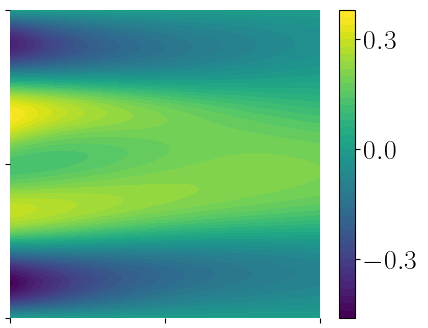

In [25]:
# u_pred plot
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*tx_fine.T,
                     u_pred,
                     levels = 50,
                     vmin= -0.4532077296610373, 
                     vmax=0.36374402)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 
# plt.savefig('onlydbry_u_pred_PINNSR.pdf',
#             dpi=300,
#             bbox_inches='tight',
#             format ="pdf"
#             )

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

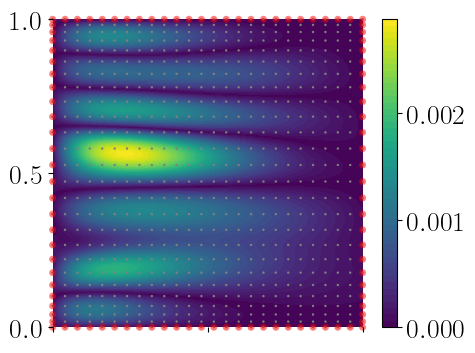

In [26]:
# u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(u_true - u_pred)/jnp.linalg.norm(u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_xticklabels([]) 

## Testing on new ICs

In [27]:
# new IC
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0
# solve Burgers with new IC
new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2884.47it/s]


In [29]:
# set u_model to collocate the PDE
u_operators = (eval_k,dx_k,dt_k,dxx_k)
# u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,
                     dx_k,
                     dxx_k)

k_u = get_gaussianRBF(jnp.sqrt(0.025/2))


u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

In [30]:
def get_u_pde_adj(u0_new):
    
    # Phat of PINNSR method
    @jit
    def get_pred_ut_PINNSR(input_features):

        coeffs = data_out_PINNSR[0].flatten()

        return input_features @ coeffs

    # Observations at ICs and BCs
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])
    new_obs = u0_new(tx_init_bdy) 

    # Set the PDE model
    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            CONST = jnp.ones(len(tx_int))
            
            U = grid_features[:,0]
            U_x = grid_features[:,1]
            U_xx = grid_features[:,2]
            
            UU = jnp.multiply(U,U)
            UU_x = jnp.multiply(U,U_x)
            UU_xx = jnp.multiply(U,U_xx)

            U_xU_x = jnp.multiply(U_x,U_x)
            U_xU_xx = jnp.multiply(U_x,U_xx)
            U_xxU_xx = jnp.multiply(U_xx,U_xx)
            

            full_features = jnp.vstack([CONST,U,U_x,U_xx,
                        UU,UU_x,UU_xx,U_xU_x,
                        U_xU_xx,U_xxU_xx]).T
            
            return full_features
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_ut_PINNSR(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jax.jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)

    ## OPTIMIZE

    optParams = LMParams(
        max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

    new_u_init = 0*u_params_init

    u_pde_params,convergence_data = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        optParams=optParams
    )
    svd_params = LMParams(
        max_iter=201,
        init_alpha=convergence_data.alpha_vals[-1],
        min_alpha=1e-16,print_every=50,
        step_adapt_multiplier=1.6)


    u_pde_params_adj,_ = SVD_LM(u_pde_params,PdeModel,beta = 1e-16,optParams=svd_params)

    return u_pde_params_adj

In [31]:
# solve Burgers with new IC 
new_u_params = get_u_pde_adj(new_u_true_function)

  2%|▏         | 6/251 [00:27<13:48,  3.38s/it]  

Iteration 0, loss = 7.22e-06, gradnorm = 145.1, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 5.009e-06, gradnorm = 1.119e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 4.021e-06, gradnorm = 2.511e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 3.492e-06, gradnorm = 1.671e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 3.176e-06, gradnorm = 1.25e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 2.947e-06, gradnorm = 9.88e-07, alpha = 0.01674, improvement_ratio = 1.0


 23%|██▎       | 58/251 [00:28<00:11, 16.86it/s]

Iteration 50, loss = 2.107e-07, gradnorm = 4.087e-08, alpha = 4.579e-06, improvement_ratio = 1.0


 43%|████▎     | 109/251 [00:29<00:03, 42.29it/s]

Iteration 100, loss = 5.875e-10, gradnorm = 3.224e-07, alpha = 5.731e-09, improvement_ratio = 0.9984


 63%|██████▎   | 159/251 [00:30<00:01, 46.27it/s]

Iteration 150, loss = 3.097e-10, gradnorm = 3.948e-07, alpha = 4.711e-09, improvement_ratio = 1.008


 83%|████████▎ | 209/251 [00:31<00:00, 46.57it/s]

Iteration 200, loss = 2.427e-10, gradnorm = 2.65e-07, alpha = 5.81e-09, improvement_ratio = 0.9923


100%|██████████| 251/251 [00:32<00:00,  7.69it/s]


Iteration 250, loss = 2.036e-10, gradnorm = 4.02e-07, alpha = 4.777e-09, improvement_ratio = 1.021


  1%|▏         | 3/201 [00:25<21:40,  6.57s/it]  

Iteration 0, loss = 2.413e-10, gradnorm = 3.359e-07, alpha = 1.722e-07, improvement_ratio = 8.601
Iteration 1, loss = 2.413e-10, gradnorm = 1.321e-07, alpha = 8.171e-07, improvement_ratio = 14.8
Iteration 2, loss = 2.413e-10, gradnorm = 1.699e-07, alpha = 7.66e-07, improvement_ratio = 10.74


  1%|▏         | 3/201 [00:25<27:58,  8.48s/it]

Line Search Failed!
Final Iteration Results
Iteration 3, loss = 2.413e-10, gradnorm = 1.699e-07, alpha = 0.004076, improvement_ratio = -182.9


In [32]:
# new_u vals at fine grid
new_u_true = new_u_true_function(tx_fine)

# new_u_pred vals at fine grid
new_u_pred = u_model.point_evaluate(tx_fine,new_u_params)

print(get_nrmse(new_u_true,new_u_pred))

0.4726128503061096


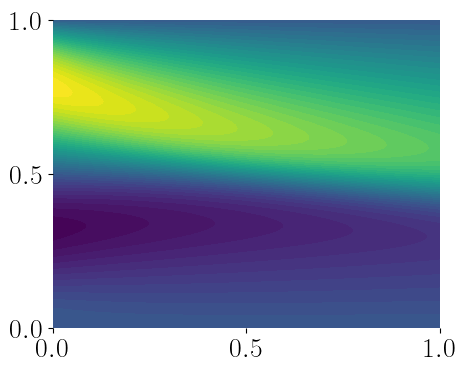

In [33]:
# new_u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, new_u_true,
                levels= 50)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

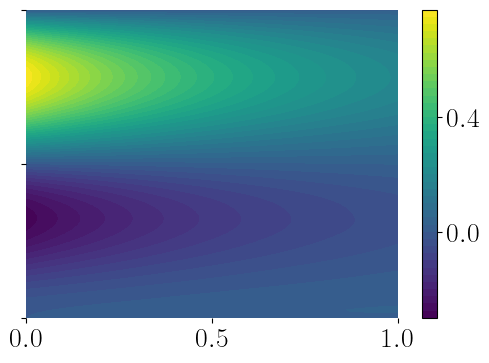

In [37]:
# new_u_pred plot
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*tx_fine.T, new_u_pred,
                levels= 50)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
# plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 

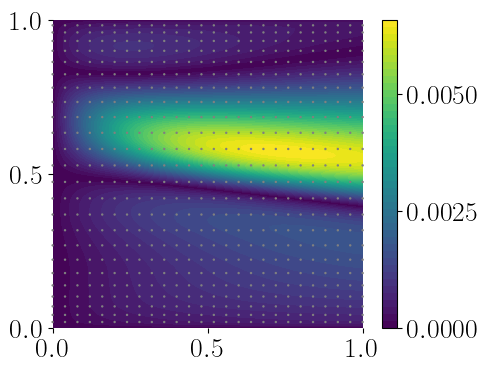

In [35]:
# new_u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(new_u_true - new_u_pred)/jnp.linalg.norm(new_u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_int.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

In [38]:
# store data
data = {'tx_obs': tx_obs,
        'tx_all': tx_all,
        'tx_int': tx_int,
        'tx_bdy': tx_bdy,
        'tx_fine': tx_fine,
        'xfine': xfine,
        'u_true': u_true,
        'u_pred': u_pred,
        'u_true_IC': u_true_IC,
        'u_true_FC': u_true_FC,
        'new_u_true': new_u_true,
        'new_u_pred': new_u_pred
}

In [39]:
# save data
np.save('data.npy', np.array(data, dtype=object), allow_pickle=True)